### This pipeline showed an end-to-end xor operator's training/inferencing example.
This cell showed the entire model.

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import plot_model
import numpy as np 

X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])

model = Sequential()
model.add(Dense(32, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])
#model_json = model.to_json()
#print(model_json)
model.fit(X, y, epochs=100, verbose=2)

In [28]:
print(X.shape)
print(y.shape)


(4, 2)
(4, 1)


In [29]:
Z = np.array([ [1,1],[1,0] ])
result=model.predict(Z)

In [30]:
print(result)
print(result.shape)

[[0.41668275]
 [0.5982964 ]]
(2, 1)


### Plot the model layers

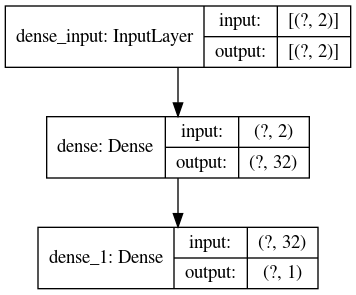

In [31]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

### Prepare for model serving
Model requires to be versioned control in kfserving. Therefore, we need to copy the model onto a new folder whose name is a number (e.g. 1 or 001)

In [32]:
model.save("gs://tsmc-demo/xor/model")
!gsutil cp -r gs://tsmc-demo/xor/model gs://tsmc-demo/models/xor-jupyter/1

INFO:tensorflow:Assets written to: gs://tsmc-demo/xor/model/assets


[I 210122 07:28:27 builder_impl:775] Assets written to: gs://tsmc-demo/xor/model/assets


Copying gs://tsmc-demo/xor/model/saved_model.pb...
/ [1 files][ 64.6 KiB/ 64.6 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://tsmc-demo/xor/model/variables/variables.data-00000-of-00001...
Copying gs://tsmc-demo/xor/model/variables/variables.index...                   
/ [3 files][ 71.0 KiB/ 71.0 KiB]                                                
Operation completed over 3 objects/71.0 KiB.                                     


In [ ]:
!pip3 install kfserving

### The following cells showed how to serve model using kfserving by using Jupyter alone. 
We need to provide ./kubeconfig as well as the application_default_credentials

In [37]:
from kubernetes import client 
from kfserving import KFServingClient

KFServing = KFServingClient(config_file="./kubeconfig.yaml")
KFServing.set_credentials(storage_type='GCS',
                          namespace='default')
namespace="default"
#KFServing.delete('xor-example', namespace=namespace)

In [38]:
from kubernetes import client

from kfserving import KFServingClient
from kfserving import constants
from kfserving import V1alpha2EndpointSpec
from kfserving import V1alpha2PredictorSpec
from kfserving import V1alpha2TensorflowSpec
from kfserving import V1alpha2InferenceServiceSpec
from kfserving import V1alpha2InferenceService


default_model_spec = V1alpha2EndpointSpec(predictor=V1alpha2PredictorSpec(tensorflow=V1alpha2TensorflowSpec(
    storage_uri='gs://tsmc-demo/models/xor-jupyter')))

isvc = V1alpha2InferenceService(api_version=constants.KFSERVING_GROUP + '/' + constants.KFSERVING_VERSION,
                          kind=constants.KFSERVING_KIND,
                          metadata=client.V1ObjectMeta(name='xor-jupyter', namespace='default'),
                          spec=V1alpha2InferenceServiceSpec(default=default_model_spec))

KFServing = KFServingClient(config_file="./kubeconfig.yaml")
KFServing.create(isvc)

[W 210122 07:33:44 kf_serving_client:99] The version v1alpha2 will be deprecated from KFServing 0.6 release.


{'apiVersion': 'serving.kubeflow.org/v1alpha2',
 'kind': 'InferenceService',
 'metadata': {'creationTimestamp': '2021-01-22T07:33:46Z',
  'generation': 1,
  'managedFields': [{'apiVersion': 'serving.kubeflow.org/v1alpha2',
    'fieldsType': 'FieldsV1',
    'fieldsV1': {'f:spec': {'.': {},
      'f:default': {'.': {},
       'f:predictor': {'.': {},
        'f:tensorflow': {'.': {}, 'f:storageUri': {}}}}}},
    'manager': 'OpenAPI-Generator',
    'operation': 'Update',
    'time': '2021-01-22T07:33:44Z'}],
  'name': 'xor-jupyter',
  'namespace': 'default',
  'resourceVersion': '10070942',
  'selfLink': '/apis/serving.kubeflow.org/v1alpha2/namespaces/default/inferenceservices/xor-jupyter',
  'uid': 'e648ed82-fb3a-4575-b2ec-be743bc4ab8a'},
 'spec': {'default': {'predictor': {'tensorflow': {'resources': {'limits': {'cpu': '1',
       'memory': '2Gi'},
      'requests': {'cpu': '1', 'memory': '2Gi'}},
     'runtimeVersion': '1.14.0',
     'storageUri': 'gs://tsmc-demo/models/xor-jupyter'}}}

### The following cell showed how to delete kfserving service from jupyter playbook.

In [41]:
KFServing = KFServingClient(config_file="./kubeconfig.yaml")
KFServing.delete('xor-jupyter', namespace='default')

{'apiVersion': 'serving.kubeflow.org/v1alpha2',
 'kind': 'InferenceService',
 'metadata': {'creationTimestamp': '2021-01-22T07:33:46Z',
  'deletionGracePeriodSeconds': 0,
  'deletionTimestamp': '2021-01-23T01:38:13Z',
  'finalizers': ['inferenceservice.finalizers'],
  'generation': 3,
  'managedFields': [{'apiVersion': 'serving.kubeflow.org/v1alpha2',
    'fieldsType': 'FieldsV1',
    'fieldsV1': {'f:spec': {'.': {},
      'f:default': {'.': {},
       'f:predictor': {'.': {},
        'f:tensorflow': {'.': {}, 'f:storageUri': {}}}}}},
    'manager': 'OpenAPI-Generator',
    'operation': 'Update',
    'time': '2021-01-22T07:33:44Z'},
   {'apiVersion': 'serving.kubeflow.org/v1beta1',
    'fieldsType': 'FieldsV1',
    'fieldsV1': {'f:metadata': {'f:finalizers': {}},
     'f:spec': {'f:predictor': {'f:containers': {},
       'f:tensorflow': {'f:args': {}, 'f:command': {}, 'f:image': {}}}},
     'f:status': {'f:address': {'.': {}, 'f:url': {}},
      'f:components': {'.': {},
       'f:pred